In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv1D,Conv2D,BatchNormalization,MaxPooling2D,AveragePooling2D,Reshape,Permute,ELU, \
  TimeDistributed, LSTM, GRU, Bidirectional
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.constraints import max_norm

2024-03-15 17:38:01.734461: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-15 17:38:01.768753: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-15 17:38:02.387915: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# For logging metrics to Weights and Biases Platform.
USING_WANDB = True  # Set to false if you don't have an account

if USING_WANDB:
    !pip install wandb &> /dev/null  # install wandb
    import wandb
    from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
    wandb.login()  # prompts for api key

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# Unzip data zip file
# !rm -r project_data
!unzip project_data.zip &> /dev/null
!rm -r __MACOSX
!mv project/* .
!rm -r project
# &> /dev/null  to quiet output

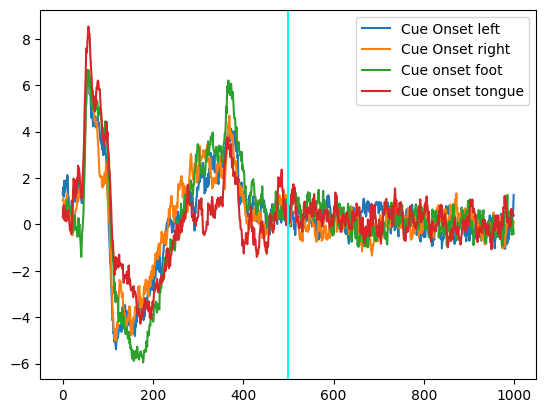

In [4]:
tf.keras.utils.set_random_seed(0)

## Loading and visualizing the data

## Loading the dataset

X_test = np.load("X_test.npy")  # (443, 22, 1000)
y_test = np.load("y_test.npy")  # (443, 4)  # (num_trials, output types) # one hot encoded
person_train_valid = np.load("person_train_valid.npy")  # (2115, 1)  vals from 0-8 for participant
X_train_valid = np.load("X_train_valid.npy")  # (2115, 22, 1000)
# print(X_train_valid.shape)  # (2115, 22, 1000)  # (num_trials, channels, time bins)
y_train_valid = np.load("y_train_valid.npy")  # (2115,)
person_test = np.load("person_test.npy")  # (443, 1)

## Adjusting the labels so that

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [6]:
def train_data_prep(X,y,sub_sample,average,noise):

    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    # Data augmentation: increases number of samples (max pool and mean pool +noise)
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    # Subsampling

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


# Don't increase the number of test samples
def test_data_prep(X):

    total_X = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)


    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X

In [7]:
num_train_valid = X_train_valid.shape[0]
print(num_train_valid, " total train_val samples")

valid_split = 0.2
valid_count = int(num_train_valid * valid_split)

2115  total train_val samples


In [8]:
# Train val split, then data augment the training set
ind_valid = np.random.choice(X_train_valid.shape[0], valid_count, replace=False)

ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))
# Creating the training and validation sets using the generated indices
(x_train_unprocessed, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train_unprocessed, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

print("Augmenting train data")
x_train, y_train = train_data_prep(x_train_unprocessed, y_train_unprocessed,2,2,True)
print("Augmenting val data")
# x_valid, y_valid = train_data_prep(x_valid, y_valid, 2, 2, True)
x_valid = test_data_prep(x_valid)
print("Augmenting test data")
X_test_prep = test_data_prep(X_test)


# Old code with data leakage
## Preprocessing the dataset
# X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True)
# X_test_prep = test_data_prep(X_test)
# ## Random splitting and reshaping the data
# # First generating the training and validation indices using random splitting
# # 8460 is shape of num_samples after data augmentation
# ind_valid = np.random.choice(8460, 1000, replace=False)
# ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))
# # Creating the training and validation sets using the generated indices
# (x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid]
# (y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)
# Note the dims of validation are diff than originally bc no longer data augment it

Augmenting train data
Shape of X after trimming: (1692, 22, 800)
Shape of X after maxpooling: (1692, 22, 400)
Shape of X after averaging+noise and concatenating: (3384, 22, 400)
Shape of X after subsampling and concatenating: (6768, 22, 400)
Shape of Y: (6768,)
Augmenting val data
Shape of X after trimming: (423, 22, 800)
Shape of X after maxpooling: (423, 22, 400)
Augmenting test data
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of training set: (6768, 22, 400)
Shape of validation set: (423, 22, 400)
Shape of training labels: (6768,)
Shape of validation labels: (423,)
Shape of training labels after categorical conversion: (6768, 4)
Shape of validation labels after categorical conversion: (423, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (6768, 22, 400, 1)
Shape of validation set after adding width info: (423, 22, 400, 1)
Shape of test set after adding width info: (443, 22, 

In [9]:
print(f"{x_train.shape[0]} train samples")
print(f"{x_valid.shape[0]} valid samples")
print(f"{X_test.shape[0]} test samples")

6768 train samples
423 valid samples
443 test samples


In [13]:
# OLD code for collapsing the data. decided instead to do it in the model
# Reshape the data for to be inputted into LSTM (num_samples, timesteps, channels)
# x_train, x_valid, x_test = x_train.squeeze(), x_valid.squeeze(), x_test.squeeze()
# print("x_train", x_train.shape)
# print("y_train", y_train.shape)
num_channels = 22
num_classes = 4
input_shape = x_train.shape[1:]
print("input_shape", input_shape)

input_shape (400, 1, 22)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute_1 (Permute)         (None, 22, 400, 1)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 22, 400, 8)        520       
                                                                 
 batch_normalization_3 (Batc  (None, 22, 400, 8)       32        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 400, 16)        2832      
                                                                 
 batch_normalization_4 (Batc  (None, 1, 400, 16)       64        
 hNormalization)                                                 
                                                                 
 elu_2 (ELU)                 (None, 1, 400, 16)       

2024-03-15 17:38:54.758652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-15 17:38:54.759231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-15 17:38:54.760062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

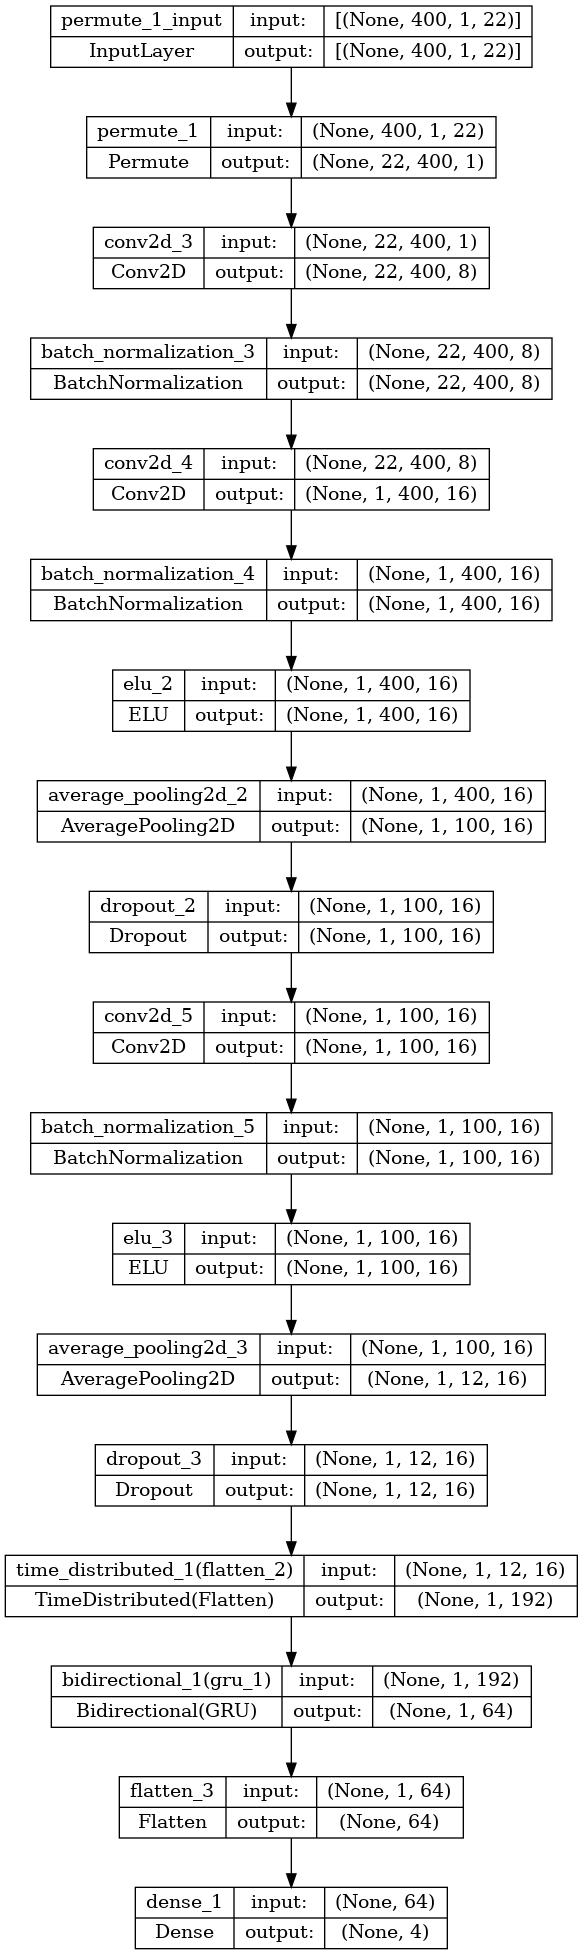

In [3]:
import visualkeras
# SEED
tf.keras.utils.set_random_seed(0)

# TODO: try .25 dropout
num_channels = 22
num_units = 32  # 32
num_hidden = 512  #16
F1 = 8
D = 2
F2 = F1 * D
dropout_rate = 0.3  # TODO  # .5 for within subject. .25 for across subject classification (larger dataset)
input_shape=(400,1,22)
num_classes=4
model = Sequential([
    Permute((3, 1, 2), input_shape=input_shape),  # now in shape (channels, time, 1)
    # 2D conv across both
    # Temporal Conv2D
    Conv2D(F1, (1,64), padding="same"),  # , activation="relu"
    BatchNormalization(),
    # Depthwise Conv2D (spatial), across channels
    Conv2D(D * F1, (num_channels, 1), padding="valid", kernel_constraint=max_norm(1)),
    BatchNormalization(),
    ELU(),
    AveragePooling2D((1, 4)),  # pool down the time dim. average pool in the paper
    Dropout(dropout_rate),
    # Separable Conv2D  (across time)
    Conv2D(F2, (1,16), padding="same"),
    BatchNormalization(),
    ELU(),
    AveragePooling2D((1,8)),
    Dropout(dropout_rate),
    TimeDistributed(Flatten()),
    Bidirectional(GRU(32, return_sequences=True)),  # w/ flatten after  32
    Flatten(),
    Dense(num_classes, activation="softmax", kernel_constraint=max_norm(0.25))
])
model.summary()
tf.keras.utils.plot_model(model, to_file="temp.png", show_shapes=True)


In [64]:
USING_WANDB = True
# Model parameters
l1_term = 0  # 0.01  pass into model
lr = 1e-3
NUM_EPOCHS = 100
batch_size = 64
patience = 5  # 3
criterion = "categorical_crossentropy"

# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)

optimizer = keras.optimizers.Adam(learning_rate=lr)
callbacks = []

# Compiling the model
callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience))
checkpoint_filepath = 'ckpt/checkpoint.model.keras'
callbacks.append(keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)
)

if USING_WANDB:
    wandb.init(
        project="EEG-ml",
        name=f"CNN+BidirGRU",
        # name=f"{conv_filters[0]}",  # i like to put a note about the current run here (e.g lr-.001 or something)
        settings=wandb.Settings(start_method="fork"),
        config = {
            "architecture": model.__class__.__name__,
            "epochs": NUM_EPOCHS,
            "learning_rate": lr,
            "batch_size": batch_size,
            "optimizer": optimizer.__class__.__name__,
            "loss fn": criterion.__class__.__name__,
            "patience": patience
            # "weight decay": weight_decay,
    })

    callbacks.append(WandbMetricsLogger())

model.compile(loss=criterion, optimizer=optimizer, metrics=['accuracy'])

# Training and validating the model
model_results = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=NUM_EPOCHS, callbacks=callbacks,
            validation_data=(x_valid, y_valid), verbose=1)  #, verbose=True)

print("Using best checkpoint for evaluation")
loaded_model = keras.models.load_model(checkpoint_filepath)
model_score = loaded_model.evaluate(x_test, y_test, verbose=0)
test_acc = model_score[1]
print(f'Test accuracy: {test_acc : .4f}')
if USING_WANDB:
    wandb.summary["Test_Acc"] = test_acc
    wandb.finish()
    # using patience 3 at .5 dropout

Epoch 1/100
106/106 [==============================] - 9s 35ms/step - loss: 1.3030 - accuracy: 0.4031 - val_loss: 1.2871 - val_accuracy: 0.3806
Epoch 2/100
106/106 [==============================] - 2s 15ms/step - loss: 1.1293 - accuracy: 0.5266 - val_loss: 1.1679 - val_accuracy: 0.4941
Epoch 3/100
106/106 [==============================] - 1s 13ms/step - loss: 1.0420 - accuracy: 0.5746 - val_loss: 1.1656 - val_accuracy: 0.4894
Epoch 4/100
106/106 [==============================] - 1s 14ms/step - loss: 0.9839 - accuracy: 0.6166 - val_loss: 1.0711 - val_accuracy: 0.5461
Epoch 5/100
106/106 [==============================] - 1s 14ms/step - loss: 0.9435 - accuracy: 0.6399 - val_loss: 1.0306 - val_accuracy: 0.5697
Epoch 6/100
106/106 [==============================] - 1s 14ms/step - loss: 0.9162 - accuracy: 0.6582 - val_loss: 1.0145 - val_accuracy: 0.5981
Epoch 7/100
106/106 [==============================] - 1s 14ms/step - loss: 0.8906 - accuracy: 0.6695 - val_loss: 1.0022 - val_accuracy:

Load the best checkpoint from training

In [66]:
loaded_model = keras.models.load_model(checkpoint_filepath)
model_score = loaded_model.evaluate(x_test, y_test, verbose=0)
test_acc = model_score[1]
print(f'Test accuracy: {test_acc : .4f}')

Test accuracy:  0.7088


Save the model to a file

In [67]:
MODEL_FILEPATH = f'pretrained_models/cnn+lstm-keras-{test_acc :.4f}'
loaded_model.save(MODEL_FILEPATH)

In [ ]:
# zip model dir and download it
zip_name = f'{MODEL_FILEPATH}.zip'
!zip -r $zip_name $MODEL_FILEPATH
from google.colab import files
files.download(zip_name)

Unzip and load a pretrained model

In [ ]:
# Unzip folder and load model
# !unzip $zip_name
# loaded_model = keras.models.load_model(MODEL_FILEPATH)
# loaded_model = keras.models.load_model('ckpt/checkpoint.model.keras')

In [50]:
model_score = loaded_model.evaluate(x_test, y_test, verbose=0)
test_acc = model_score[1]
print(f'Test accuracy: {test_acc : .4f}')

Test accuracy:  0.7088


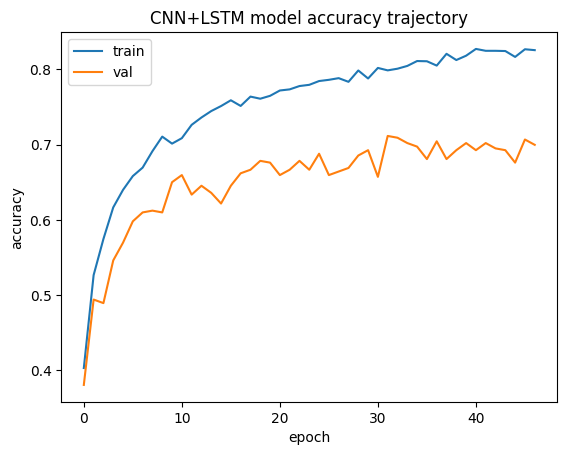

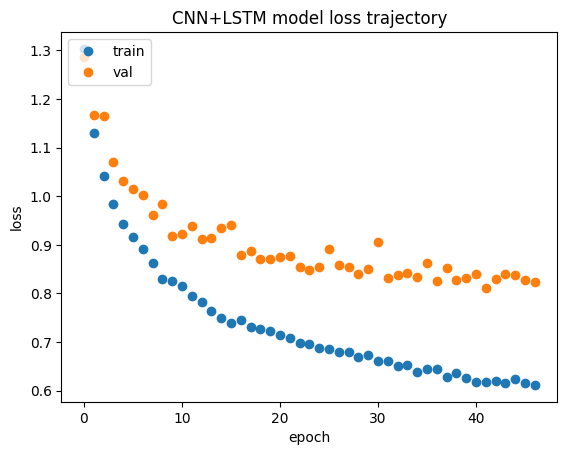

In [65]:
# Plotting accuracy trajectory
plt.plot(model_results.history['accuracy'])
plt.plot(model_results.history['val_accuracy'])
plt.title('CNN+LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(model_results.history['loss'],'o')
plt.plot(model_results.history['val_loss'],'o')
plt.title('CNN+LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()